In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

## Data
Data was collected and stored in pickle format using ```music_data.py```. Now this data can be easily loaded and used.

In [3]:
# Load the data
top_artists_df = pd.read_pickle('spotify_data/top_artists.pkl')
followed_artists_df = pd.read_pickle('spotify_data/followed_artists.pkl')
top_tracks_df = pd.read_pickle('spotify_data/top_tracks.pkl')
saved_tracks_df = pd.read_pickle('spotify_data/saved_tracks.pkl')
playlist_tracks_df = pd.read_pickle('spotify_data/playlist_tracks.pkl')
recommendation_tracks_df = pd.read_pickle('spotify_data/recommended_tracks.pkl')

In [4]:
# Remove duplicate tracks
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()

# Remove tracks which are present in both playlist_tracks_df and recommendation_tracks_df
recommendation_tracks_df = recommendation_tracks_df[~recommendation_tracks_df['id'].isin(playlist_tracks_df['id'].tolist())]

## Create Ratings

To make this a classification problem, i have classified all tracks in playlist_tracks_df as 1 which appear in top_tracks_df or saved_tracks_df. The rest are classified as 0

In [5]:
count = 0
rating_list = list()
for id in playlist_tracks_df.id:
    if id in top_tracks_df.id.values or id in saved_tracks_df.id.values:
        count = count + 1
        # 1 to the tracks from top tracks and saved tracks
        rating_list.append(1)
    else:
        # 0 otherwise
        rating_list.append(0)

print(f'Number of tracks marked as 1 --> {count}')

# Add new column 'ratings' to the dataframe
playlist_tracks_df['ratings'] = rating_list

playlist_tracks_df.head()

Number of tracks marked as 1 --> 146


,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings
0,0,2jRu7tJH0Imf0IrNrTGNEk,"Blue Bird (From ""Naruto Shippuden"") [Chillhop]",45,track,False,False,114593,1,4,...,0.219,0.539000,0.144,0.5570,90.030,spotify:track:2jRu7tJH0Imf0IrNrTGNEk,https://api.spotify.com/v1/tracks/2jRu7tJH0Imf...,https://api.spotify.com/v1/audio-analysis/2jRu...,4,1
1,1,3GkSDGupydidufnOGZn2FE,Peach,62,track,False,False,136525,1,1,...,0.406,0.907000,0.105,0.6350,118.009,spotify:track:3GkSDGupydidufnOGZn2FE,https://api.spotify.com/v1/tracks/3GkSDGupydid...,https://api.spotify.com/v1/audio-analysis/3GkS...,4,0
2,2,0hiTwMBveSSLOcA608KRCh,Blue Bird Lofi,50,track,False,False,162037,1,1,...,0.595,0.000004,0.740,0.7190,119.849,spotify:track:0hiTwMBveSSLOcA608KRCh,https://api.spotify.com/v1/tracks/0hiTwMBveSSL...,https://api.spotify.com/v1/audio-analysis/0hiT...,4,0
3,3,7pFRhCj70NUNZG4xMDEQj8,Soul Mates,65,track,False,False,96343,1,1,...,0.407,0.311000,0.251,0.3700,74.980,spotify:track:7pFRhCj70NUNZG4xMDEQj8,https://api.spotify.com/v1/tracks/7pFRhCj70NUN...,https://api.spotify.com/v1/audio-analysis/7pFR...,4,0
4,4,4zlT73vpaaTJfqfRjjX1RQ,Uncertain Truth,60,track,False,False,148363,1,1,...,0.284,0.751000,0.106,0.0408,109.977,spotify:track:4zlT73vpaaTJfqfRjjX1RQ,https://api.spotify.com/v1/tracks/4zlT73vpaaTJ...,https://api.spotify.com/v1/audio-analysis/4zlT...,4,0


## Features

We have some features like 'danceability', 'energy', 'key' which were pulled directly from the track audio features using the Spotify Web API. But there are features like the different genres which are given as a list under genres. We need to expand all these genres into their own columns and use one-hot encoding to specify if the particular track is of this(1) genre or not(0).

In [6]:
# Training data
X = playlist_tracks_df[['popularity','explicit','duration_ms','danceability', 'energy', 'key', 'loudness', 'mode',
                        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                        'time_signature', 'genres']]

y = playlist_tracks_df['ratings']

# Drop NaN or None
X = X.dropna()
recommendation_tracks_df = recommendation_tracks_df.dropna()

# Create genre columns (one-hot encoding)
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_tracks_df.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())

# Ensure features are consistent across training, test, and evaluation
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

<ipython-input-6-65efa8aec24e>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
<ipython-input-6-65efa8aec24e>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())


## Feature Selection

Currently we have 448 features, we will reduce the number of features to better train the model and reduce on computation

Fitting estimator with 448 features.
Fitting estimator with 447 features.
Fitting estimator with 446 features.
Fitting estimator with 445 features.
Fitting estimator with 444 features.
Fitting estimator with 443 features.
Fitting estimator with 442 features.
Fitting estimator with 441 features.
Fitting estimator with 440 features.
Fitting estimator with 439 features.
Fitting estimator with 438 features.
Fitting estimator with 437 features.
Fitting estimator with 436 features.
Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
F

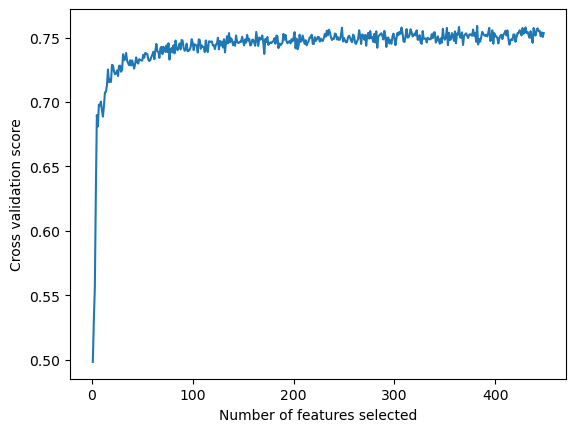

In [14]:
# Recursive Feature Elimination with Cross-Validation (RFECV) is used to rank features
# estimator -> Machine Learning algorithm instance to be used, i have used Random Forest with 1000 trees
# step -> Number of features to remove per iteration
# cv -> cross validation splitting strategy, StratifiedKFold(2) splits data into 2 folds. Works well with imbalance dataset
# scoring -> scoring metric used to optimize for
# verbose --> Setting this to 1 will print updates onto the console on every iteration
# n_jobs --> Number of cores to run in parallel. -1 means all available cores


rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(2),  scoring='roc_auc', verbose=1, n_jobs=-1)
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

We can see that the Optimal number of features is 382 whereas the total number of features we have is 448. This means we can get rid of 66 features.

In [21]:
# Dropping the least important features
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_recommend.drop(X_recommend.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

/Users/veersingh/opt/anaconda3/envs/recsysspotify/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
# Saving X_train, y_train, X_test, y_test, X_recommend for use in ML models
X_train.to_csv('training/X_train.csv')
X_train.to_pickle('training/X_train.pkl')

y_train.to_csv('training/y_train.csv')
y_train.to_pickle('training/y_train.pkl')

X_test.to_csv('training/X_test.csv')
X_test.to_pickle('training/X_test.pkl')

y_test.to_csv('training/y_test.csv')
y_test.to_pickle('training/y_test.pkl')

X_recommend.to_csv('training/X_recommend.csv')
X_recommend.to_pickle('training/X_recommend.pkl')

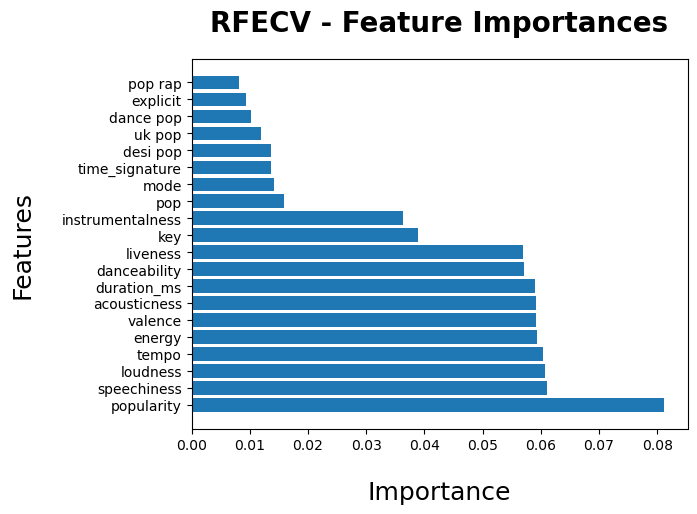

In [54]:
# Visualize importance of 20 of most important features (showing all 382 would not be possible in such a small space)

X_train = pd.read_pickle('training/X_train.pkl')

dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by=['importance'], ascending=False)
dset = dset.head(20)

plt.figure()
plt.barh(y=dset['attr'], width=dset['importance'])
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=18, labelpad=20)
plt.ylabel('Features', fontsize=18, labelpad=20)
plt.show()